# Importing the relevant libraries

In [1]:
# Importing the relevant libraries
import numpy as np
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import os, glob, shutil
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import json
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Flatten
from keras.layers import Input, Concatenate
from keras.models import Model

In [2]:
from tqdm import tqdm
import re
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [3]:
# Load and preprocess the sneaker images
SIZE = 256
_img = []
path = '/sneakers1_images/sneakers1_images/'
files = os.listdir(path)
files = sorted(files)
for i in files:
    img = cv2.imread(path + i)
    if img is None:
        print(f"Image '{i}' not found.")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = (img - 127.5) / 127.5
    _img.append(img)

Image '.ipynb_checkpoints' not found.


## Visualise the images

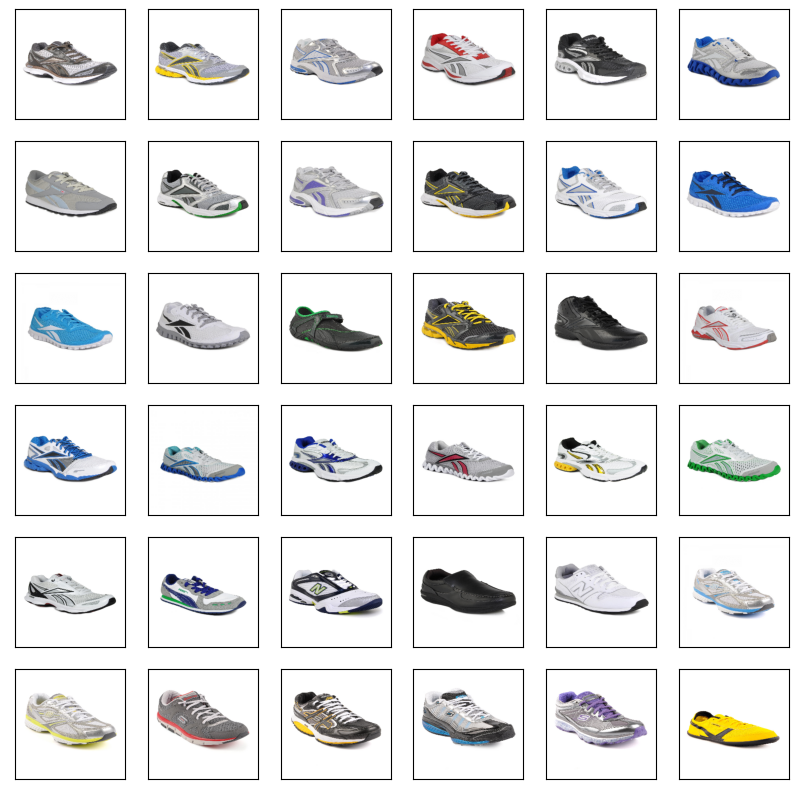

In [4]:
# Visualise the images
# Define the plot_images function
def plot_images(sqr=5):
    plt.figure(figsize=(10, 10))
    plt.title("Real Images", fontsize=35)
    for i in range(sqr * sqr):
        plt.subplot(sqr, sqr, i+1)
        plt.imshow(_img[i] * 0.5 + 0.5)
        plt.xticks([])
        plt.yticks([])

# Check if the _img list is not empty
if len(_img) > 0:
    # Call the plot_images function
    plot_images(6)
else:
    print("No images found or an error occurred during image processing.")


In [5]:
# Convert the image data to a NumPy array
image_data = np.array(_img)

# Define the batch size for training
batch_size = 32


In [6]:
# Create a TensorFlow dataset from the image data
dataset = tf.data.Dataset.from_tensor_slices(image_data).batch(batch_size)

## Generator

In [7]:
# Generator
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64 * 64 * 3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((64, 64, 3)))
    model.add(tf.keras.layers.Conv2D(64, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(64, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh'))  # Update strides to 2
    return model



In [8]:
# Create the generator
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12288)             1228800   
                                                                 
 reshape (Reshape)           (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        3072      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        65536     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                        

## Discriminator

In [9]:
# Discriminator
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((256, 256, 3)))  # Update the input shape to (256, 256, 3)
    model.add(tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model


In [10]:
# Create the discriminator
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 128)     6144      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 128)      

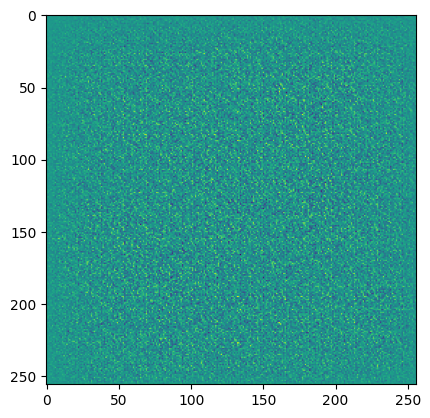

In [11]:
# Plot generated images before training
noise = np.random.normal(-1, 1, (1, latent_dim))
img = generator(noise)
plt.imshow(img[0, :, :, 0])
plt.show()

## Defining optimizer and loss function

In [12]:


# Define the optimizer
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.0001,
    clipvalue=1.0
)

# Define the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator loss function
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss



## Defining training steps

In [13]:
# Define training steps
def train_steps(images):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)

    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    loss = {'gen loss': gen_loss,
            'disc loss': disc_loss}
    return loss

## Defining function to plot generated images

In [14]:
# Function to plot generated images
def plot_generated_images(square=5, epochs=0):
    plt.figure(figsize=(10, 10))
    for i in range(square * square):
        if epochs != 0:
            if (i == square // 2):
                plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize=32, color='black')
        plt.subplot(square, square, i + 1)
        noise = np.random.normal(0, 1, (1, latent_dim))
        img = generator(noise)
        plt.imshow(np.clip((img[0, ...] + 1) / 2, 0, 1))

        plt.xticks([])
        plt.yticks([])
        plt.grid()

## Compiling the generator and discriminator models

In [17]:
# Compile the generator and discriminator models
generator.compile(optimizer=optimizer, loss=generator_loss, metrics=['accuracy'])
discriminator.compile(optimizer=optimizer, loss=discriminator_loss, metrics=['accuracy'])

## Training

In [18]:
import time
gen_losses = []
disc_losses = []

# Training
def train(epochs, dataset):
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
            gen_losses.append(loss['gen loss'])
            disc_losses.append(loss['disc loss'])
        print("Time: {}".format(np.round(time.time() - start), 2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'], loss['disc loss']))
            

    # Plot generator and discriminator losses against epochs
    plt.plot(range(1, len(gen_losses) + 1), gen_losses, label='Generator Loss')
    plt.plot(range(1, len(disc_losses) + 1), disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## Training the GAN on sneakers images


Epoch : 1
Time: 15.0
Generator Loss: 2.84389328956604 Discriminator Loss: 0.1529751867055893

Epoch : 2
Time: 12.0
Generator Loss: 0.7553739547729492 Discriminator Loss: 0.6963679194450378

Epoch : 3
Time: 13.0
Generator Loss: 0.48402169346809387 Discriminator Loss: 0.9878455996513367

Epoch : 4
Time: 13.0
Generator Loss: 1.0828367471694946 Discriminator Loss: 0.42687398195266724

Epoch : 5
Time: 13.0
Generator Loss: 0.8298896551132202 Discriminator Loss: 0.7227026224136353

Epoch : 6
Time: 13.0
Generator Loss: 1.031775712966919 Discriminator Loss: 0.5666806101799011

Epoch : 7
Time: 13.0
Generator Loss: 0.7340980768203735 Discriminator Loss: 0.8634815216064453

Epoch : 8
Time: 13.0
Generator Loss: 1.3584673404693604 Discriminator Loss: 0.6031194925308228

Epoch : 9
Time: 13.0
Generator Loss: 1.1425849199295044 Discriminator Loss: 0.6947128772735596

Epoch : 10
Time: 13.0
Generator Loss: 1.877868413925171 Discriminator Loss: 0.4292999505996704

Epoch : 11
Time: 13.0
Generator Loss: 7.

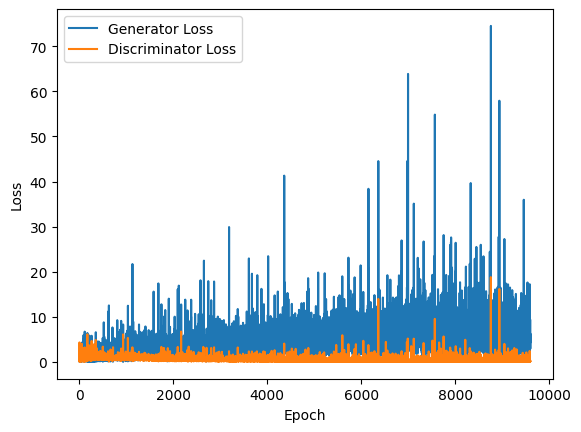

In [19]:
# Training the GAN on fashion product images
train(150, dataset)

## Plotting Generated Sneakers Images

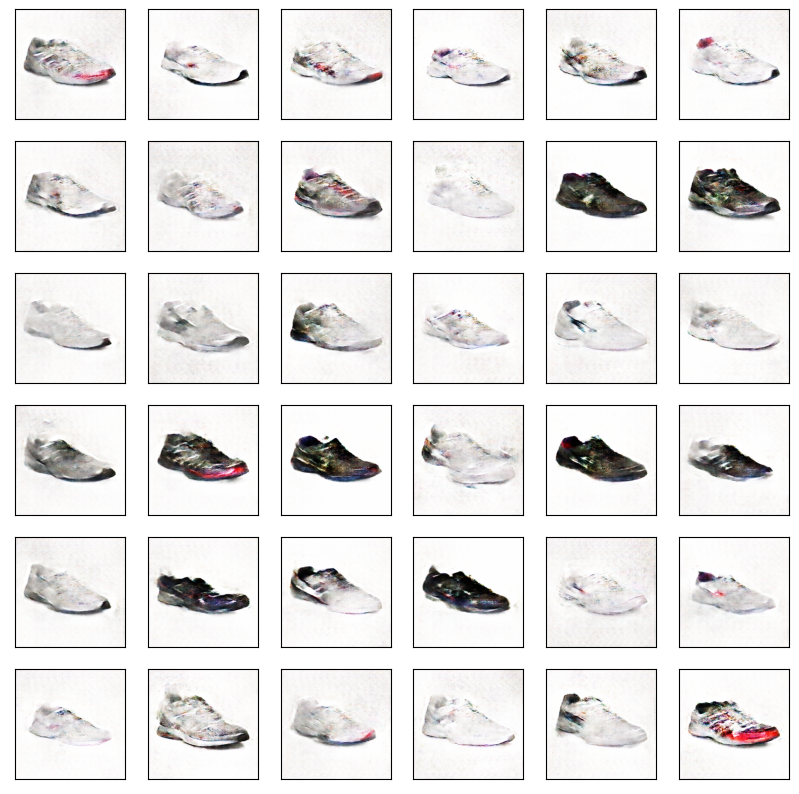

In [20]:
# Plot generated sneakers images
plot_generated_images(6)

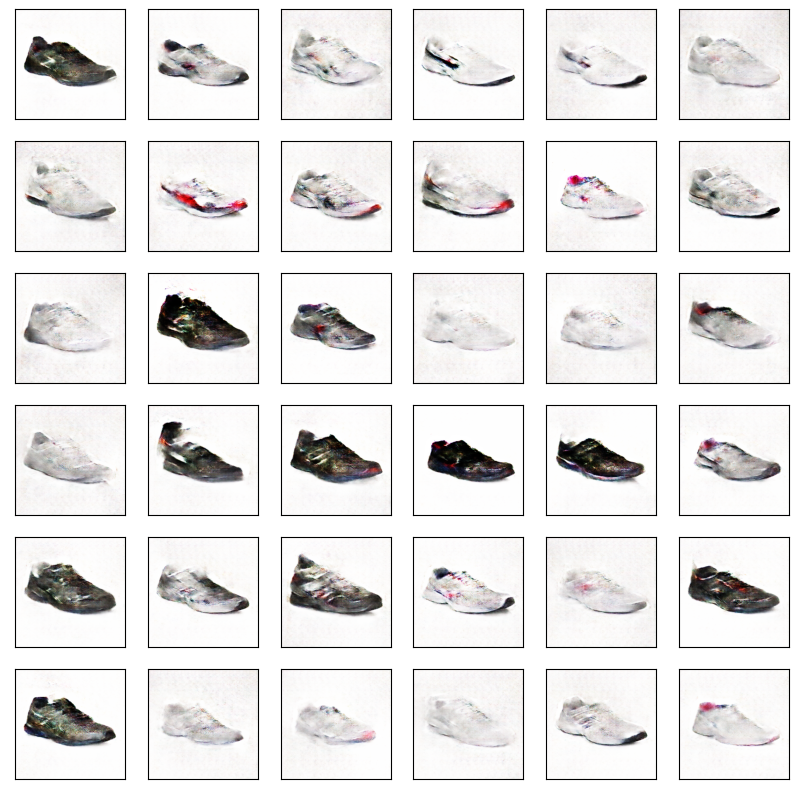

In [126]:
# Plot generated sneakers images
plot_generated_images(6)

## Saving the Generator and Discriminator Model

In [56]:
generator.save('sneakers_generator.h5')
discriminator.save("sneakers_discriminator.h5")

## Splitting the GAN photo grid into individual images

In [57]:
# Path to the folder containing the GAN photo grid images
folder_path = '/sneakers_generated'

# Get the list of files in the folder
files = os.listdir(folder_path)

# Create a directory for saving the individual images
output_folder = os.path.join(folder_path, 'fake_images')
os.makedirs(output_folder, exist_ok=True)

# Loop through each file
for file_name in files:
    # Check if the file is an image
    if file_name.endswith('.png'):
        # Load the GAN photo grid image
        sneakers_generated_grid = cv2.imread(os.path.join(folder_path, file_name))

        # Get the dimensions of the grid image
        height, width, _ = sneakers_generated_grid.shape

        # Define the size of each individual image
        image_height = height // 6
        image_width = width // 6

        # Split the GAN photo grid into individual images
        fake_images = []
        for row in range(6):
            for col in range(6):
                # Compute the coordinates for each individual image
                y_start = row * image_height
                y_end = (row + 1) * image_height
                x_start = col * image_width
                x_end = (col + 1) * image_width

                # Crop the GAN photo grid to extract the individual image
                fake_image = sneakers_generated_grid[y_start:y_end, x_start:x_end]
                fake_images.append(fake_image)

            
        for i, image in enumerate(fake_images):
            filename, extension = os.path.splitext(file_name)
            output_file = os.path.join(output_folder, f'{filename}_{i+1}{extension}')
            cv2.imwrite(output_file, image)


## Evaluating the GAN Model through FID and Inception Score using torch

# FID

In [58]:
# Importing the relevant libraries
import torch
from torchvision.transforms import ToTensor, Resize
from PIL import Image
from torchvision.models import inception_v3
import torch.nn.functional as F
import numpy as np
import os
import torch.nn as nn
from torchvision.transforms import transforms

In [59]:
# Define function to calculate the activation statistics of the images
def calculate_activation_statistics(images, model):
    # Set model to evaluation mode
    model.eval()

    # Calculate activations
    with torch.no_grad():
        activations = model(images)[0]

    # Reshape activations
    activations = activations.reshape(activations.shape[0], -1)

    # Calculate mean and covariance of activations
    mu = torch.mean(activations, dim=0)
    sigma = torch_cov(activations, unbiased=True)

    return mu, sigma


In [60]:
def torch_cov(x, unbiased=False, rowvar=True):
    # Compute covariance matrix
    if x.dim() > 2:
        raise ValueError('x has more than 2 dimensions')

    if x.dim() < 2:
        x = x.view(1, -1)

    if not rowvar and x.shape[0] != 1:
        x = x.t()

    fact = 1.0 - float(unbiased) / float(x.shape[0])
    x -= torch.mean(x, dim=1, keepdim=True)
    cov = torch.matmul(x, x.t()) * (1.0 / float(x.shape[1])) * fact

    return cov


In [61]:
def calculate_fid(real_images, generated_images):
    # Resize images to a consistent size
    real_images = F.interpolate(real_images, size=(299, 299), mode='bilinear', align_corners=False)
    generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

    # Load InceptionV3 model
    model = inception_v3(pretrained=True, transform_input=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    real_images = real_images.to(device)
    generated_images = generated_images.to(device)

    # Calculate activation statistics for real and generated images
    mu_real, sigma_real = calculate_activation_statistics(real_images, model)
    mu_generated, sigma_generated = calculate_activation_statistics(generated_images, model)

    # Calculate FID score
    mu_diff = mu_real - mu_generated
    cov_sqrt = torch.sqrt(torch.matmul(sigma_real, sigma_generated))
    fid_score = torch.norm(mu_diff, 2) + torch.trace(sigma_real + sigma_generated - 2 * cov_sqrt)

    return fid_score.item()

In [62]:
# Load real images
real_image_paths = ['sneakers1_images/10035.jpg', 'sneakers1_images/10037.jpg']
real_images = []
for path in real_image_paths:
    img = Image.open(path).convert('RGB')
    img = Resize((256, 256))(img)  # Resize the image to a consistent size
    img = ToTensor()(img)  # Convert PIL image to PyTorch tensor
    real_images.append(img)
real_images = torch.stack(real_images, dim=0)

In [63]:
# Load generated images
generated_image_paths = ['fake_images/sneakers_generated11_10.png', 'fake_images/sneakers_generated11_11.png']
generated_images = []
for path in generated_image_paths:
    img = Image.open(path).convert('RGB')
    img = Resize((256, 256))(img)  # Resize the image to a consistent size
    img = ToTensor()(img)  # Convert PIL image to PyTorch tensor
    generated_images.append(img)
generated_images = torch.stack(generated_images, dim=0)

In [64]:
# Calculate FID score
fid = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid}")

C:\Users\x\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\x\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 0.005165554583072662


## Calculating the Inception Score

In [65]:
def calculate_inception_score(fake_image_path, real_image_path, batch_size=64):
    # Load the Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    inception_model.fc = nn.Identity()

 

    # Load and preprocess the real images
    real_images = load_images(real_image_path)
    real_activations = get_activations(real_images, inception_model, batch_size)

 

    # Load and preprocess the fake images
    fake_images = load_images(fake_image_path)
    fake_activations = get_activations(fake_images, inception_model, batch_size)

 

    # Calculate the Inception scores
    real_scores = calculate_scores(real_activations)
    fake_scores = calculate_scores(fake_activations)

 

    # Return the mean Inception Score and standard deviation
    return np.mean(fake_scores), np.std(fake_scores)


In [66]:
def load_images(image_path):
    image_files = os.listdir(image_path)
    images = []
    
    # Define image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    for filename in image_files:
        image = Image.open(os.path.join(image_path, filename))
        image = transform(image)
        images.append(image)
    return torch.stack(images)

In [67]:
def get_activations(images, model, batch_size):
    activations = []
    num_batches = int(np.ceil(len(images) / batch_size))
    
    # Loop through batches of images
    for i in range(num_batches):
        batch = images[i * batch_size : (i + 1) * batch_size]
        
        # Compute activations and convert to numpy array
        batch_activations = model(batch).detach().cpu().numpy()
        activations.append(batch_activations)
        
        # Concatenate activations from all batches
    activations = np.concatenate(activations)
    return activations

In [68]:
def calculate_scores(activations):
    scores = []
    for sample_activations in activations:
        true_distribution = np.mean(activations, axis=0)
        epsilon = 1e-10  # epsilon value to avoid division by zero and taking the logarithm of zero
        kl_divergence = sample_activations * (np.log(sample_activations + epsilon) - np.log(true_distribution + epsilon))
        kl_divergence = np.mean(kl_divergence)
        scores.append(np.exp(kl_divergence))
    return scores

In [69]:
# Example usage
fake_image_path = r"fake_images/"
real_image_path = r"sneakers1_images/"
inception_score_mean, inception_score_std = calculate_inception_score(fake_image_path, real_image_path)
print("Inception Score (mean):", inception_score_mean)
print("Inception Score (std):", inception_score_std)

Inception Score (mean): 1.084921
Inception Score (std): 0.0438
